***
# **Competencia: Modelos Avanzados PLN**
# Evaluación

**Rúbrica:** Este archivo debe incluir las funciones creadas para la generación de los JSONs para los correos de prueba de la partición de test. Asegúrense de que este archivo cargue los pesos de weights.pt y lea directamente el archivo eval.json.

Este notebook genera el archivo `submission_norm.csv` para subir a Kaggle.

***
## Integrantes Equipo 20
- Andrés Felipe Ñungo Fernández
- Andrés Julián Gonzalez Barrera
- Hernando Jose Jimenez Díaz
- Gloria Inés López Urbano

# Índice

El notebook ejecuta el pipeline de evaluación con la siguiente estructura:

- Sección 1: Instalación e importe de librerías y cargue del modelo entrenado `weights.pt`.
- Sección 2: Carga de datos y construcción prompt
- Sección 3: Inferencia
- Sección 4: Guardar resultados

Arquitectura modular:
- shared_functions.py: Funciones de generación y extracción de JSON
- clean_fields_json.py: Funciones de normalización y limpieza de campos
- evaluation.ipynb: Orquestación del pipeline completo

# 1. Instalación e importe de librerías

Carga de todas las dependencias necesarias para el pipeline de evaluación.

Librerías estándar de Python:
- os, json, random, gc, time: Utilidades del sistema y gestión de memoria

Librerías de ciencia de datos:
- matplotlib, numpy, pandas: Visualización y manipulación de datos

Módulos personalizados del equipo:
- shared_functions: Funciones compartidas entre notebooks (generación, extracción)
- clean_fields_json: Funciones de normalización y limpieza de campos JSON

Librerías de Machine Learning:
- torch: Framework de deep learning
- peft: Parameter-Efficient Fine-Tuning (LoRA)
- datasets: Manejo de conjuntos de datos de HuggingFace
- transformers: Modelos y tokenizers pre-entrenados

Configuración de logging: Se suprime el nivel de advertencia de transformers para evitar mensajes repetitivos durante la carga del modelo.

In [1]:
import os
import json
import random
import gc
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shared_functions as custom_sharfun
import clean_fields_json as custom_clean_fields

import torch
from peft import PeftModel, LoraConfig
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)
from transformers import logging as hf_logging
hf_logging.set_verbosity_warning()

## 1.1 Definición de variables globales y funciones auxiliares

Definición de funciones utilitarias para gestión de memoria y configuración del entorno de ejecución.

### Función: clean_memory()

Gestión de memoria RAM y VRAM de GPU.

Propósito:
Liberar memoria no utilizada para prevenir errores Out-Of-Memory durante la inferencia. Es especialmente importante en notebooks donde múltiples celdas pueden acumular objetos en memoria.

Implementación:
- Ejecuta el garbage collector de Python para liberar objetos no referenciados
- Limpia la caché de CUDA si hay GPU disponible

In [2]:
def clean_memory():
    "Limpia VRAM agresivamente"
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

### Limpieza inicial de memoria

Ejecución de limpieza de memoria antes de cargar el modelo.

Contexto: Garantiza máxima memoria disponible para la carga del modelo cuantizado y sus adaptadores LoRA. Si se ejecutaron otros notebooks en la misma sesión, esta celda libera memoria residual.

In [3]:
clean_memory()

### Configuración de directorios y dispositivo

Definición de rutas del proyecto:
- OUTPUT_DIR: Directorio raíz con resultados del entrenamiento (versión v10)
- ADAPTER_DIR: Subdirectorio con el checkpoint final del modelo (modfinal_full)

Estos paths deben coincidir exactamente con los utilizados en train.ipynb. El archivo weights.pt debe existir en ADAPTER_DIR.

Detección de dispositivo:
El sistema detecta automáticamente la disponibilidad de GPU (CUDA). Si no hay GPU disponible, se utiliza CPU automáticamente, aunque la inferencia será significativamente más lenta.

In [4]:
# Directorios y modelos
OUTPUT_DIR = "output/results/v11"
ADAPTER_DIR = os.path.join(OUTPUT_DIR, "modfinal_full")

# Configuración del dispositivo
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


### Carga del modelo fine-tuneado desde checkpoint personalizado

Proceso completo de restauración del modelo usando el formato weights.pt generado durante el entrenamiento.

- Etapa 1: Carga del checkpoint
- Etapa 2: Restauración del Tokenizer
- Etapa 3: Configuración de cuantización 4-bit
- Etapa 4: Carga del modelo base cuantizado
- Etapa 5: Configuración de adaptadores LoRA
- Etapa 6: Ensamblaje del modelo completo

Estructura del archivo weights.pt:
El checkpoint contiene un diccionario con los siguientes componentes:
- tokenizer: ID del tokenizer base
- model_id: ID del modelo base
- bnb_config: Configuración de cuantización BitsAndBytes
- config: Diccionario con hiperparámetros de entrenamiento y configuración LoRA
- peft: OrderedDict con los pesos entrenados de los adaptadores LoRA

Uso de memoria:
El modelo base cuantizado ocupa aproximadamente 600MB de VRAM. Los adaptadores LoRA agregan 50-100MB adicionales. El total es aproximadamente 700-800MB de VRAM, comparado con aproximadamente 2.4GB sin cuantización.

In [5]:
pt_file = os.path.join(ADAPTER_DIR, "weights.pt")
pt_loaded = torch.load(pt_file, map_location=DEVICE, weights_only=False)

print("Cargando tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(pt_loaded["tokenizer"])
tokenizer.padding_side = "left" # A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("Cargando modelo base en 4 bits...")
bnb_config = BitsAndBytesConfig(**pt_loaded["bnb_config"])

print("Modelo base:", pt_loaded["model_id"])
model_base = AutoModelForCausalLM.from_pretrained(
    pt_loaded["model_id"],
    quantization_config=bnb_config, 
    device_map="auto"
)

print("Cargando modelo LoRA...")
# Debes usar la misma configuración LoRA que usaste al entrenar
config_lora = LoraConfig(
    r = pt_loaded["config"]["lora_r"],
    lora_alpha = pt_loaded["config"]["lora_alpha"],
    lora_dropout = pt_loaded["config"]["lora_drop"],
    target_modules = pt_loaded["config"]["lora_target_mods"],
    bias=pt_loaded["config"]["lora_bias"],
    task_type=pt_loaded["config"]["lora_task_type"]
)

model = PeftModel(model_base, config_lora)
model.load_state_dict(pt_loaded["peft"], strict=False)

model.eval()

Cargando tokenizer...
Cargando modelo base en 4 bits...
Modelo base: Qwen/Qwen3-0.6B-Base
Cargando modelo LoRA...


PeftModel(
  (base_model): LoraModel(
    (model): Qwen3ForCausalLM(
      (model): Qwen3Model(
        (embed_tokens): Embedding(151936, 1024)
        (layers): ModuleList(
          (0-27): 28 x Qwen3DecoderLayer(
            (self_attn): Qwen3Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=1024, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear4bi

### Configuración de hiperparámetros de inferencia

**Parámetros de longitud de secuencias:**

**MAX_LENGTH = 2048**
Longitud máxima del prompt más contexto en tokens. Aumentado desde 1500 en versiones anteriores para manejar órdenes de compra complejas con múltiples productos y direcciones sin truncar información crítica.

**GEN_MAX_NEW_TOKENS = 512**
Número máximo de tokens que el modelo puede generar. Aumentado desde 377 en versiones anteriores. Garantiza espacio suficiente para JSONs con múltiples elementos en arrays de purchases y addresses.

**BATCH_SIZE_EVAL = 14**
Número de ejemplos procesados simultáneamente durante la inferencia. Este valor está optimizado para GPUs con 8-16GB de VRAM. Si se encuentran errores de memoria, reducir a 8-10. Si se dispone de más de 16GB de VRAM, se puede aumentar a 20-24 para inferencia más rápida.

**Semilla de reproducibilidad:**
Se utiliza la misma semilla que durante el entrenamiento, extraída del checkpoint. Esto garantiza consistencia en los resultados. La semilla se establece en todas las librerías relevantes: torch, random, numpy, y CUDA.

Impacto de los cambios de versiones anteriores:
Los aumentos en MAX_LENGTH y GEN_MAX_NEW_TOKENS reducen el truncamiento de JSONs complejos y mejoran el F1-score en ejemplos largos. El costo es un incremento aproximado del 15-20 por ciento en tiempo de inferencia y 10-15 por ciento en uso de memoria.

In [6]:
    # Data / tokenization
MAX_LENGTH = 2048
# Evaluación
GEN_MAX_NEW_TOKENS = 512
BATCH_SIZE_EVAL = 14 # ajustar según memoria GPU para ejecutar más rápido la evaluación

# Semilla de entrenamiento
GLB_SEED = pt_loaded["config"]["seed"]
torch.manual_seed(GLB_SEED)
random.seed(GLB_SEED)
np.random.seed(GLB_SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(GLB_SEED)

# 2. Carga de datos y construcción de prompts

Carga del conjunto de evaluación y análisis exploratorio de los datos.

Contenido de esta sección:
- Carga del archivo JSON con datos de evaluación
- Análisis de distribución de longitudes de texto
- Conversión a formato Dataset de HuggingFace para procesamiento eficiente
- Verificación de estructura de datos

Archivo esperado: data/eval/eval.json
Este archivo contiene los ejemplos finales para generar predicciones que se subirán a Kaggle.

In [7]:
DATA_PATH = "data/eval/eval.json" 
with open(DATA_PATH, "r", encoding="utf-8") as f:
    raw_data = json.load(f)
print(f"Número de ejemplos de evaluación: {len(raw_data)}")

Número de ejemplos de evaluación: 1000


### Análisis exploratorio: distribución de longitudes de texto

Visualización mediante histograma de la distribución de longitudes de los textos en natural_language.

Propósito del análisis:
- Identificar textos extremadamente largos que podrían truncarse con la configuración actual
- Verificar que MAX_LENGTH es suficiente para la mayoría de ejemplos
- Detectar outliers que requieran atención especial

Interpretación del histograma:
El pico principal indica la longitud típica de las órdenes de compra. La cola derecha muestra ejemplos complejos con múltiples productos o direcciones. Si hay textos que exceden 2048 caracteres (aproximadamente 512 tokens), podrían truncarse con la configuración actual de MAX_LENGTH.

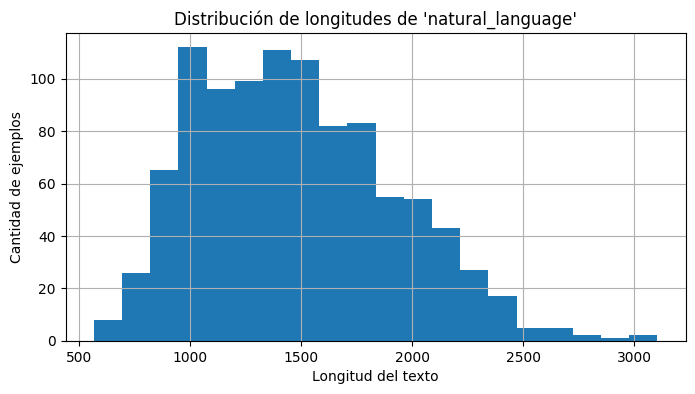

In [8]:
# Obtener longitudes - histograma
longitudes = [len(item["natural_language"]) for item in raw_data]
plt.figure(figsize=(8, 4))
plt.hist(longitudes, bins=20)  # puedes ajustar el número de bins
plt.title("Distribución de longitudes de 'natural_language'")
plt.xlabel("Longitud del texto")
plt.ylabel("Cantidad de ejemplos")
plt.grid(True)
plt.show()

### Conversión a formato HuggingFace Dataset

Transformación del JSON raw a un objeto Dataset para compatibilidad con las funciones de procesamiento del equipo.

Ventajas del formato Dataset:
- Indexación eficiente mediante Apache Arrow
- Compatibilidad directa con funciones de shared_functions.py
- Métodos integrados para procesamiento por lotes
- Lazy loading para datasets grandes que no caben en memoria

El tipo resultante es datasets.arrow_dataset.Dataset, que proporciona acceso eficiente a los datos mediante indexación y slicing estándar de Python.

In [9]:
# Cargar directamente un archivo JSON
val_list = load_dataset('json', data_files=DATA_PATH)['train']
print(type(val_list))  # Será datasets.Dataset

<class 'datasets.arrow_dataset.Dataset'>


# 3. Inferencia

Pipeline de generación de predicciones sobre el conjunto de evaluación completo.

Proceso implementado:
1. Extracción de textos e IDs del dataset
2. Generación de JSONs mediante procesamiento por lotes con generate_json_raw_batch
3. Extracción y validación de JSONs desde las salidas crudas del modelo
4. Construcción de estructura de resultados con formato id-prediction
5. Medición y reporte de tiempo de ejecución

Funciones utilizadas desde shared_functions.py:
- generate_json_raw_batch: Generación eficiente en batches con construcción automática de prompts
- extract_json_from_text: Extracción robusta de JSON desde texto con manejo de errores
- print_time_execution: Formateo legible de tiempos de ejecución

### Generación de predicciones completa

Ejecución del pipeline de inferencia sobre todos los ejemplos del conjunto de evaluación.

Paso 1: Preparación de datos
Se extraen listas paralelas de textos e IDs del dataset. Es crucial mantener la correspondencia exacta entre cada texto y su ID para el archivo de submission final.

Paso 2: Generación por batches
La función generate_json_raw_batch procesa los ejemplos en lotes del tamaño especificado. Internamente construye los prompts automáticamente, tokeniza con padding y truncation, y genera las salidas usando configuración determinista (do_sample=False) para garantizar reproducibilidad.

Paso 3: Post-procesamiento
Para cada salida cruda del modelo, se intenta extraer un JSON válido. La función extract_json_from_text busca el primer bloque delimitado por llaves y valida que sea JSON sintácticamente correcto. Si la extracción falla, se asigna un diccionario vacío como fallback.

Paso 4: Construcción de resultados
Se crea una lista de diccionarios con el formato requerido: cada elemento contiene el id original y la prediction como objeto Python (dict). Este formato facilita la posterior normalización y serialización.

Paso 5: Medición de performance
Se registra y muestra el tiempo total de inferencia. Esta métrica es útil para comparar performance entre versiones del modelo y optimizaciones del código.

Optimizaciones aplicadas:
- Batch processing reduce tiempo aproximadamente 10x comparado con procesamiento secuencial
- KV-cache activado (use_cache=True) reutiliza cálculos de atención entre tokens
- Cuantización 4-bit reduce latencia de inferencia
- Left-padding mejora eficiencia en modelos decoder-only al alinear contenido relevante

In [10]:
start_time = time.time()

print(f"Generando predicciones: total datos = {len(val_list)} ...")

texts = [ex["natural_language"] for ex in val_list]
ids = [ex["id"] for ex in val_list]

pred_raw_list = custom_sharfun.generate_json_raw_batch( texts=texts, tokenizer=tokenizer, model=model, device=DEVICE, max_new_tokens=GEN_MAX_NEW_TOKENS,  max_length=MAX_LENGTH, batch_size=BATCH_SIZE_EVAL )
results_submission = []
for id_save, raw in zip(ids, pred_raw_list):
    pred_obj = custom_sharfun.extract_json_from_text(raw)
    if pred_obj is None:
        pred_obj = {}
    results_submission.append({
        "id": id_save,
        "prediction": pred_obj
    })

end_time = time.time()
print( custom_sharfun.print_time_execution("Generación de predicciones", start_time, end_time) )

Generando predicciones: total datos = 1000 ...


Generating:   0%|          | 0/72 [00:00<?, ?it/s]

Tiempo Generación de predicciones: 38 minutos y 58.06 segundos


### Conversión a DataFrame de pandas

Transformación de la lista de resultados a DataFrame para facilitar manipulación, visualización y aplicación de transformaciones.

El DataFrame tiene dos columnas: id (entero) y prediction (dict de Python). Esta estructura intermedia permite aplicar funciones de normalización de forma vectorizada antes de la serialización final a CSV.

In [11]:
df_results2 = pd.DataFrame(results_submission, columns=["id", "prediction"])

# Guardar resultados

Pipeline de post-procesamiento y exportación de predicciones.

Etapas del proceso:
1. Creación de directorio de salida para archivos finales
2. Guardado de respaldo en formato JSON para debugging y análisis
3. Normalización de estructura según schema esperado por la competencia
4. Serialización a formato CSV con especificaciones de Kaggle

Archivos generados:
- submission_2.json: Respaldo en formato JSON legible para inspección manual
- submission_norm.csv: Archivo oficial normalizado para subir a Kaggle

La normalización es crítica porque el modelo puede generar JSONs con campos faltantes, tipos incorrectos o estructuras incompletas. El proceso de limpieza garantiza consistencia con el schema esperado.

In [12]:
CSV_DIR = os.path.join(OUTPUT_DIR, "csvfinal")
os.makedirs(CSV_DIR, exist_ok=True)

## Guardar copia en formato JSON

Creación de un respaldo legible de las predicciones antes de la transformación a CSV.

Utilidad del respaldo:
- Debugging: Permite inspeccionar predicciones individuales fácilmente
- Validación: Verificar estructura antes de normalización
- Recovery: Regenerar CSV sin ejecutar inferencia nuevamente
- Análisis: Facilita análisis post-competencia de errores y aciertos

In [13]:
OUTPUT_JSON2 = os.path.join(CSV_DIR, "submission_2.json")
with open(OUTPUT_JSON2, "w", encoding="utf-8") as f:
    json.dump(results_submission, f, ensure_ascii=False, indent=4)

### Transformaciones post-predicción

Aplicación del pipeline de normalización a todas las predicciones del DataFrame.

Este proceso utiliza funciones del módulo clean_fields_json.py para garantizar que todas las predicciones cumplan con el schema esperado, incluso si el modelo generó salidas incompletas o con errores de formato.

In [14]:
df_results_normalized = df_results2.copy()
df_results_normalized = df_results_normalized.copy()

# Normalizar al esquema esperado
df_results_normalized['normalized_prediction'] = df_results_normalized['prediction'].apply(lambda x: custom_clean_fields.normalize_example_json_pred(x))
df_results_normalized_csv = df_results_normalized[["id", "normalized_prediction"]].copy()

In [15]:
# Convertir la columna JSON a texto
df_results_normalized_csv["prediction"] = df_results_normalized_csv["normalized_prediction"].apply(custom_clean_fields.serialize_info)
df_results_normalized_csv = df_results_normalized_csv.drop(columns=["normalized_prediction"])

## Guardar archivo CSV

Preparación del archivo final para Kaggle mediante transformaciones específicas.

Requisitos del formato CSV de Kaggle:
1. Columnas exactas: id y prediction
2. prediction debe ser string JSON, no objeto Python
3. Estructura normalizada según schema de la competencia
4. Manejo explícito de campos null según especificaciones

Las siguientes celdas implementan el proceso de normalización y serialización.

In [16]:
# Guardar en CSV
OUTPUT_CSV = os.path.join(CSV_DIR, "submission_norm.csv")
df_results_normalized_csv.to_csv(OUTPUT_CSV, index=False)
print(f"Resultados guardados en {OUTPUT_CSV}")

Resultados guardados en output/results/v11\csvfinal\submission_norm.csv
